# Import statements

In [1]:
# Imports for plotting.
from matplotlib import pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
from matplotlib.ticker import MultipleLocator
from pylab import *
import seaborn as sns
from matplotlib import rc
rc('text',
   usetex=True)
sns.set_style('ticks')
font = {
    'font.family':'Times New Roman',
    'font.weight': 200,
    'font.size': 10,
}
sns.set_style(font)
flatui = ['#002A5E', '#FD151B', '#8EBA42', '#348ABD', '#988ED5', '#BDB76B', '#8EBA42', '#FFB5B8']
sns.set_palette(flatui)
paper_rc = {
    'lines.linewidth': 2,
    'lines.markersize': 10,
    'mathtext.fontset': 'custom',
    'mathtext.rm': 'Times New Roman',
    'mathtext.bf': 'Times New Roman:bold',
}
sns.set_context("paper", font_scale=2,  rc=paper_rc)
current_palette = sns.color_palette()

In [2]:
# Other imports.
import os
import re

# Get logfile paths

In [3]:
def get_logfile_paths_helper(directory_name):
    logfile_paths = []
    for root, _, file_names in os.walk(directory_name):
        if len(file_names) > 0:
            logfile_paths.extend(
                [os.path.join(root, file_name)
                 for file_name in file_names])
    return logfile_paths

def get_logfile_paths(directory_name):
    logfile_paths = []
    for logfile_path in get_logfile_paths_helper(directory_name):
        m = re.match(
            r'.*v100=(\d+)\.p100=(\d+)\.k80=(\d+)/(.*)/'
             'lambda=(\d+\.\d+)\.log', logfile_path)
        v100s = int(m.group(1))
        p100s = int(m.group(2))
        k80s = int(m.group(3))
        policy = m.group(4)
        l = float(m.group(5))
        logfile_paths.append((v100s, p100s, k80s, policy, l,
                              logfile_path))
    return logfile_paths

In [4]:
policies = ["fifo", "isolated", "max_min_fairness",
            "max_min_fairness_packed"]
logfile_paths = sorted(get_logfile_paths("/lfs/1/keshav2/gpusched/scheduler/logs/2019-07-25/"))

# Plotting functions

In [5]:
def prune(logfile_paths, v100s, p100s, k80s, policy):
    return sorted([(x[4], x[5]) for x in logfile_paths
                   if x[0] == v100s and x[1] == p100s and
                   x[2] == k80s and x[3] == policy])

labels = {"fifo": "FIFO", "isolated": "MMF", "max_min_fairness": "MMF+perf",
          "max_min_fairness_packed": "MMF+perf+packed"}
def plot_metric_vs_inverse_lambda(v100s, p100s, k80s, policies, metric_fn,
                                  metric_label, xmax=None, ymax=None,
                                  output_filename=None):
    plt.figure(figsize=(7, 3))
    ax = plt.subplot2grid((1, 1), (0, 0), colspan=1)

    for policy in policies:
        relevant_logfile_paths = list(reversed(prune(
            logfile_paths, v100s, p100s, k80s, policy)))
        lambdas = [x[0] for x in relevant_logfile_paths]
        input_job_rates = [3600.0 / x for x in lambdas]
        metrics = [metric_fn(x[1]) for x in relevant_logfile_paths]
        ax.plot(input_job_rates, metrics,
                linewidth=3, label=labels[policy],
                marker='o')

    ax.set_xlabel("Input job rate (jobs/hr)")
    ax.set_ylabel(metric_label)
    ax.set_xlim([0, xmax])
    ax.set_ylim([0, ymax])
    sns.despine()
    
    leg = plt.figlegend(ncol=2, loc='upper center', frameon=False)
    bb = leg.get_bbox_to_anchor().inverse_transformed(ax.transAxes)
    y_offset = 0.23
    x_offset = 0
    bb.y0 += y_offset
    bb.y1 += y_offset
    bb.x0 += x_offset
    bb.x1 += x_offset
    leg.set_bbox_to_anchor(bb, transform=ax.transAxes)
    plt.draw()
    
    if output_filename is not None:
        with PdfPages(output_filename) as pdf:
            pdf.savefig(bbox_inches='tight')
    
    plt.show()

# Plot average JCT versus input job rate

In [6]:
def average_jct_fn(logfile_path, min_job_id=None, max_job_id=None):
    job_completion_times = []
    with open(logfile_path, 'r') as f:
        lines = f.readlines()
        for line in lines[-10000:]:
            m = re.match(r'Job (\d+): (\d+\.\d+)', line)
            if m is not None:
                job_id = int(m.group(1))
                job_completion_time = float(m.group(2))
                if min_job_id is None or min_job_id <= job_id:
                    if max_job_id is None or job_id <= max_job_id:
                        job_completion_times.append(
                            job_completion_time)
    if len(job_completion_times) == 0:
        return 1e4 # Run timed out.
    return np.mean(job_completion_times) / 3600

V100s=25, P100s=0, K80s=0; Jobs 4000-5000


findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


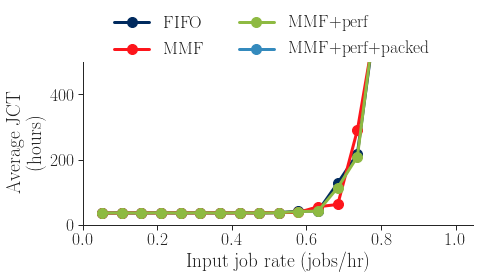

In [7]:
print("V100s=25, P100s=0, K80s=0; Jobs 4000-5000")
plot_metric_vs_inverse_lambda(
    v100s=25, p100s=0, k80s=0,
    policies=policies,
    metric_fn=lambda x: average_jct_fn(x, min_job_id=4000, max_job_id=5000),
    metric_label="Average JCT\n(hours)",
    ymax=500.0
)

V100s=12, P100s=12, K80s=0; Jobs 4000-5000


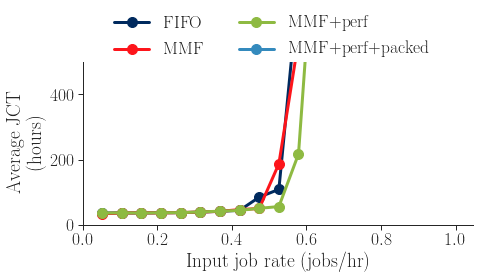

In [8]:
print("V100s=12, P100s=12, K80s=0; Jobs 4000-5000")
plot_metric_vs_inverse_lambda(
    v100s=12, p100s=12, k80s=0,
    policies=policies,
    metric_fn=lambda x: average_jct_fn(x, min_job_id=4000, max_job_id=5000),
    metric_label="Average JCT\n(hours)",
    ymax=500.0
)

V100s=16, P100s=8, K80s=0; Jobs 4000-5000


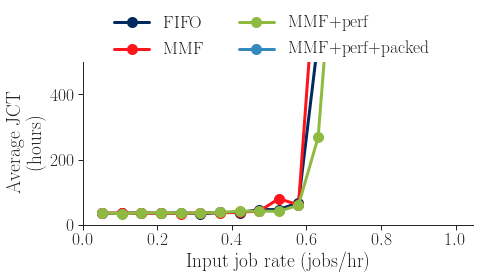

In [9]:
print("V100s=16, P100s=8, K80s=0; Jobs 4000-5000")
plot_metric_vs_inverse_lambda(
    v100s=16, p100s=8, k80s=0,
    policies=policies,
    metric_fn=lambda x: average_jct_fn(x, min_job_id=4000, max_job_id=5000),
    metric_label="Average JCT\n(hours)",
    ymax=500.0
)

V100s=8, P100s=8, K80s=8; Jobs 4000-5000


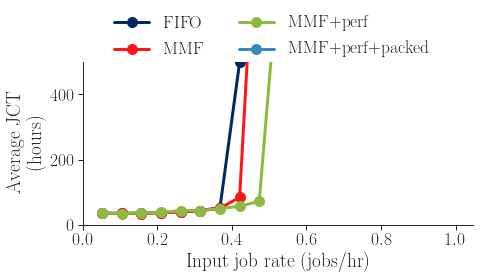

In [10]:
print("V100s=8, P100s=8, K80s=8; Jobs 4000-5000")
plot_metric_vs_inverse_lambda(
    v100s=8, p100s=8, k80s=8,
    policies=policies,
    metric_fn=lambda x: average_jct_fn(x, min_job_id=4000, max_job_id=5000),
    metric_label="Average JCT\n(hours)",
    ymax=500.0
)

# Plot utilization versus input job rate

In [11]:
def utilization_fn(logfile_path):
    job_completion_times = []
    with open(logfile_path, 'r') as f:
        lines = f.readlines()
        for line in lines[-10000:]:
            m = re.match(r'Cluster utilization: (\d+\.\d+)', line)
            if m is not None:
                return float(m.group(1)) * 100.

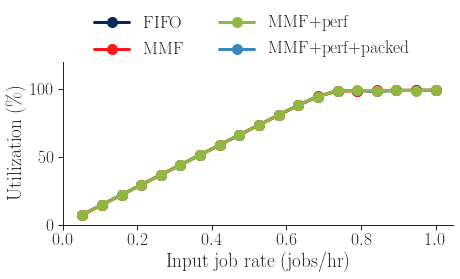

In [12]:
plot_metric_vs_inverse_lambda(
    v100s=25, p100s=0, k80s=0,
    policies=policies,
    metric_fn=utilization_fn,
    metric_label="Utilization (\%)",
    ymax=120.
)

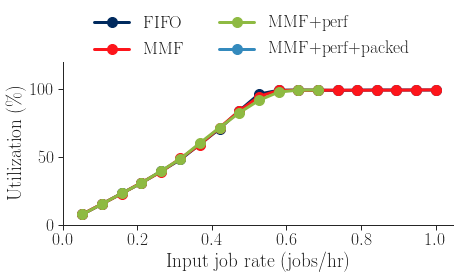

In [13]:
plot_metric_vs_inverse_lambda(
    v100s=12, p100s=12, k80s=0,
    policies=policies,
    metric_fn=utilization_fn,
    metric_label="Utilization (\%)",
    ymax=120.0
)

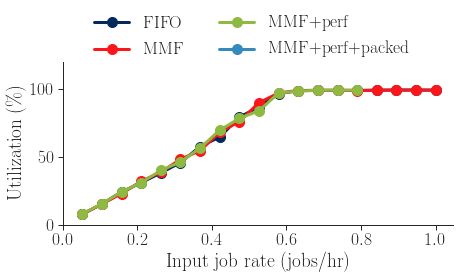

In [14]:
plot_metric_vs_inverse_lambda(
    v100s=16, p100s=8, k80s=0,
    policies=policies,
    metric_fn=utilization_fn,
    metric_label="Utilization (\%)",
    ymax=120.0
)

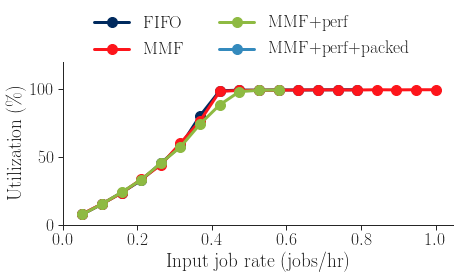

In [15]:
plot_metric_vs_inverse_lambda(
    v100s=8, p100s=8, k80s=8,
    policies=policies,
    metric_fn=utilization_fn,
    metric_label="Utilization (\%)",
    ymax=120.0
)

# Plot output job rate versus input job rate

In [16]:
def output_job_rate_fn(logfile_path, num_jobs=5000):
    job_completion_times = []
    with open(logfile_path, 'r') as f:
        lines = f.readlines()
        for line in lines[-10000:]:
            m = re.match(r'Total duration: (\d+\.\d+) seconds', line)
            if m is not None:
                return num_jobs / (float(m.group(1)) / 3600.)

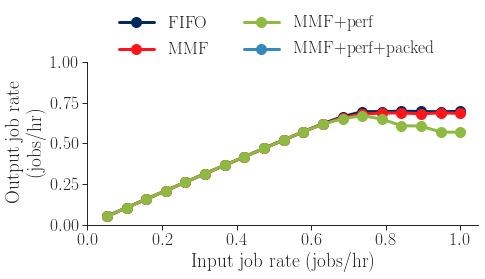

In [17]:
plot_metric_vs_inverse_lambda(
    v100s=25, p100s=0, k80s=0,
    policies=policies,
    metric_fn=output_job_rate_fn,
    metric_label="Output job rate\n(jobs/hr)",
    ymax=1.0
)

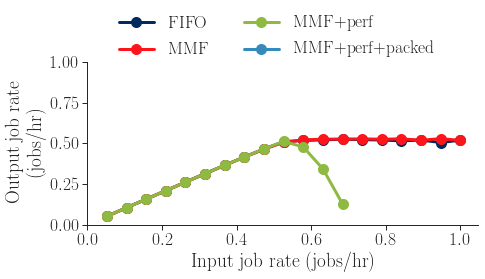

In [18]:
plot_metric_vs_inverse_lambda(
    v100s=12, p100s=12, k80s=0,
    policies=policies,
    metric_fn=output_job_rate_fn,
    metric_label="Output job rate\n(jobs/hr)",
    ymax=1.0
)

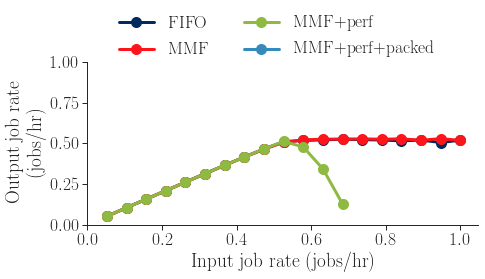

In [19]:
plot_metric_vs_inverse_lambda(
    v100s=12, p100s=12, k80s=0,
    policies=policies,
    metric_fn=output_job_rate_fn,
    metric_label="Output job rate\n(jobs/hr)",
    ymax=1.0
)

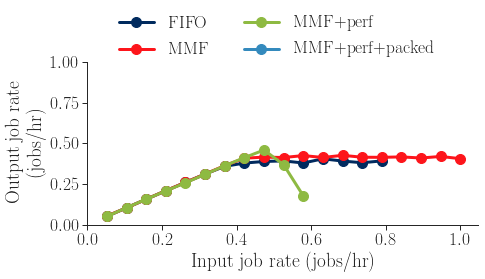

In [20]:
plot_metric_vs_inverse_lambda(
    v100s=8, p100s=8, k80s=8,
    policies=policies,
    metric_fn=output_job_rate_fn,
    metric_label="Output job rate\n(jobs/hr)",
    ymax=1.0
)